In [1]:
"""
Model code for:
Interdependent Diffusion: The social contagion of interacting beliefs
James Houghton
October 12, 2019

Written using:
- Python 3.7.1
- NetworkX 2.3
- Pandas 0.24.2
- Scikit-learn 0.20.1

This code is slower than it needs to be, in order to make each operation explicit.

To import this module into another python file or jupyter notebook, call:
    from example_code import *

To run a matched simulation of interdependent and independent diffusion, call:
    result = run()

To run a number of simulations and average their output, call:
    n_sims = 10
    df = pd.concat([run() for i in range(n_sims)])
    result = df.groupby(level=0).aggregate('mean')

"""

import networkx as nx
import numpy as np
import itertools
import pandas as pd
import copy
from sklearn.decomposition import PCA


def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.node[agent]:  # has exogenous susceptibility defined (independent case)
        return g.node[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            return nx.shortest_path_length(g.node[agent]['M'], *belief) <= 2  # current holders are also susceptible
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False  # no path exists between the nodes


def adopt(g, agent, belief):
    """Assess whether an agent will adopt a given belief"""
    suscep = susceptible(g, agent, belief)
    exposed = any([belief in g.node[nbr]['M'].edges() for nbr in g[agent]])
    return suscep and exposed  # both susceptibility and exposure required to adopt


def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    res = {}  # dictionary to collect measurements

    # Fig 3A: Susceptible and adopting populations
    # --------------------------------------------
    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.node[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

    # Fig 3B:correlation between predicted new adoption and actual new adoption
    # -------------------------------------------------------------------------
    if initial_adopted is not None and initial_susceptible is not None:  # t>0
        res['initial prediction correlation'] = np.corrcoef(
            adopt.sum(axis=0) - initial_adopted,
            initial_susceptible - initial_adopted
        )[1, 0]  # select an off-diagonal term
    else:  # first time => establish baseline
        initial_adopted = adopt.sum(axis=0)
        initial_susceptible = suscep.sum(axis=0)
        res['initial prediction correlation'] = np.nan  # measure has no meaning at t0

    # Fig 3C: correlation between a belief and it's most popular neighbor
    # -------------------------------------------------------------------
    adopt_counts = pd.DataFrame()
    adopt_counts['self'] = adopt.sum(axis=0)
    adopt_counts['leading neighbor'] = 0
    for c1 in adopt.columns:
        # search for the leading neighbor's popularity
        leading_value = 0
        for c2 in adopt.columns:
            if len((set(c1) | set(c2))) == 3:  # three nodes total => c1 and c2 are neighbors
                leading_value = max(leading_value, adopt_counts.loc[[c2], 'self'].values[0])
        adopt_counts.at[[c1], 'leading neighbor'] = leading_value
    res['leading neighbor correlation'] = adopt_counts.corr().loc['self', 'leading neighbor']

    # Fig 3D: clustering coefficient of 10% most popular beliefs
    # ----------------------------------------------------------
    # shuffle within sorted value so that when 10% falls within a level of popularity
    # we don't add spurious clustering by selecting sequential beliefs
    adopt_counts['shuffle'] = np.random.rand(len(adopt_counts))
    adopt_counts.sort_values(by=['self', 'shuffle'], inplace=True, ascending=False)
    leaders = adopt_counts.iloc[:int(len(adopt_counts) * 0.1)]  # take leading 10% of beliefs
    popular_graph = nx.from_edgelist(list(leaders.index))  # construct semantic network from leading beliefs
    res['popular belief clustering'] = nx.average_clustering(popular_graph)

    # Fig 5A: similarity btw 5% and 95% most similar pairs
    # ----------------------------------------------------
    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res, initial_susceptible, initial_adopted


def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.node[agent]['M'].edges()], axis=0)

    m0, initial_susceptible, initial_adopted = measure(g, beliefs)  # measure initial conditions
    m = [m0]  # array to collect measurements at each time step

    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.node[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network
        m.append(measure(g, beliefs, initial_susceptible, initial_adopted)[0])  # ignore returned init suscep and adopt

    return pd.DataFrame(m)  # format as pandas DataFrame


def run(n_agents=40, deg=3, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model timestep at which the interdependent results will be
                                        must be less than n_steps
    n_steps: (integer) - Number of timesteps in the model
    """

    # Shared Initial Setup
    # --------------------
    # create a random connected social network g0
    connected = False
    while not connected:
        g0 = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
        connected = nx.is_connected(g0)

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Interdependent simulation
    # -------------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Independent simulation
    # ----------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions

    # calculate the population likelihood of being susceptible to a given (non-held) belief
    p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
         (1 - res1.loc[0, '% adopted']))

    # choose a set of beliefs for each agent to be susceptible to
    new_sus = {}
    for agent in g2:
        gc = nx.complete_graph(n_concepts)  # potentially susceptible to any belief
        gc.remove_edges_from(g2.node[agent]['M'].edges())  # temporarily remove existing beliefs
        # from remainder, randomly select a subset of beliefs to be susceptible to
        edges = list(itertools.compress(
            list(gc.edges()),  # selection candidates
            np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
        ))
        edges += list(g2.node[agent]['M'].edges())  # add susceptibility to existing beliefs
        new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

    nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame


In [2]:
# to run a single simulation
result = run()
result

## Match independent susceptibility to the initial state of the interdependent case

In [17]:
# to average a number of simulations
n_sims = 10
df = pd.concat([run() for i in range(n_sims)])
result = df.groupby(level=0).aggregate('mean')
result

,% adopted (inter),% susceptible (inter),5% similarity (inter),95% similarity (inter),PC1 percent of variance (inter),initial prediction correlation (inter),leading neighbor correlation (inter),popular belief clustering (inter),% adopted (indep),% susceptible (indep),5% similarity (indep),95% similarity (indep),PC1 percent of variance (indep),initial prediction correlation (indep),leading neighbor correlation (indep),popular belief clustering (indep)
0,0.085946,0.219159,-0.094028,0.085611,4.525046,NaN,-0.023762,0.069893,0.085946,0.219062,-0.094028,0.085611,4.525046,NaN,-0.023762,0.051775
1,0.149185,0.370766,-0.091255,0.192925,7.508898,0.316212,0.153327,0.162079,0.121631,0.219062,-0.090299,0.152437,5.446571,0.407536,-0.034476,0.058232
2,0.284704,0.542239,-0.097640,0.302456,13.975388,0.246780,0.286288,0.264535,0.126854,0.219062,-0.090452,0.159616,5.648074,0.452504,-0.035461,0.068883
3,0.443050,0.631611,-0.101129,0.353061,15.970561,0.207323,0.410277,0.349657,0.127533,0.219062,-0.088785,0.161724,5.650978,0.457549,-0.029162,0.064764
4,0.531837,0.657778,-0.119527,0.370496,14.154323,0.199236,0.464585,0.465471,0.127636,0.219062,-0.088285,0.162311,5.643122,0.458849,-0.028479,0.059943
5,0.559130,0.663377,-0.132162,0.376558,14.028183,0.196218,0.496717,0.492429,0.127644,0.219062,-0.088285,0.162311,5.642822,0.459100,-0.028652,0.054313
6,0.567920,0.664688,-0.137712,0.374666,13.900764,0.199299,0.504667,0.464191,0.127644,0.219062,-0.088285,0.162311,5.642822,0.459100,-0.028652,0.058936
7,0.571095,0.664979,-0.140605,0.374084,13.961902,0.202828,0.505231,0.446490,0.127644,0.219062,-0.088285,0.162311,5.642822,0.459100,-0.028652,0.064471
8,0.572175,0.665253,-0.140751,0.375939,13.954828,0.203386,0.505256,0.454806,0.127644,0.219062,-0.088285,0.162311,5.642822,0.459100,-0.028652,0.065001
9,0.572501,0.665262,-0.141539,0.375805,13.952442,0.204176,0.504539,0.465513,0.127644,0.219062,-0.088285,0.162311,5.642822,0.459100,-0.028652,0.060973


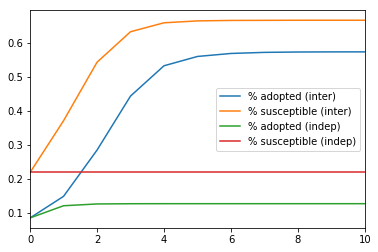

In [18]:
result[['% adopted (inter)', '% susceptible (inter)', '% adopted (indep)', '% susceptible (indep)']].plot();

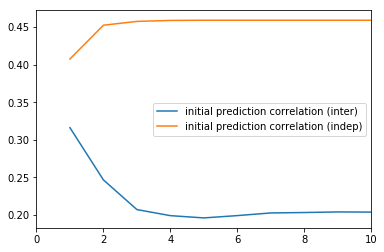

In [19]:
result[['initial prediction correlation (inter)', 'initial prediction correlation (indep)']].plot();

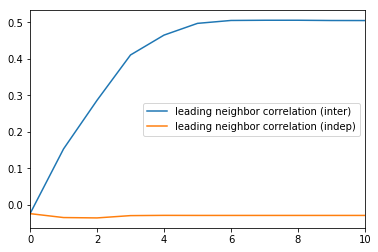

In [21]:
result[['leading neighbor correlation (inter)', 'leading neighbor correlation (indep)']].plot();

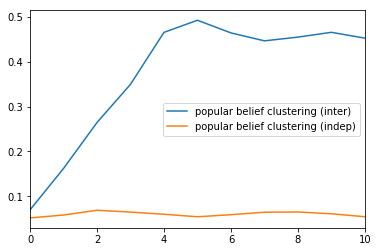

In [22]:
result[['popular belief clustering (inter)', 'popular belief clustering (indep)']].plot();

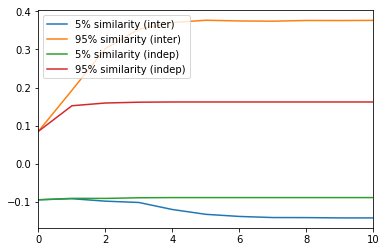

In [23]:
result[['5% similarity (inter)', '95% similarity (inter)', 
        '5% similarity (indep)', '95% similarity (indep)']].plot();

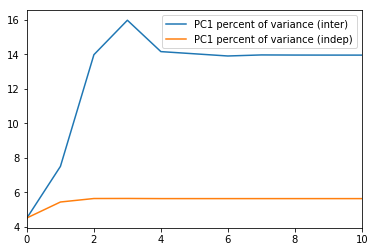

In [24]:
result[['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)']].plot()

## Match susceptibility to the final state of the interdependent case

In [25]:
# to average a number of simulations
n_sims = 10
df = pd.concat([run(t_match_susceptibility=9) for i in range(n_sims)])
result = df.groupby(level=0).aggregate('mean')
result

,% adopted (inter),% susceptible (inter),5% similarity (inter),95% similarity (inter),PC1 percent of variance (inter),initial prediction correlation (inter),leading neighbor correlation (inter),popular belief clustering (inter),% adopted (indep),% susceptible (indep),5% similarity (indep),95% similarity (indep),PC1 percent of variance (indep),initial prediction correlation (indep),leading neighbor correlation (indep),popular belief clustering (indep)
0,0.086398,0.220641,-0.094570,0.089328,4.500400,NaN,0.020615,0.038826,0.086398,0.670363,-0.094570,0.089328,4.500400,NaN,0.020615,0.047282
1,0.148225,0.363834,-0.092205,0.186343,7.683203,0.292278,0.127738,0.114828,0.317885,0.670363,-0.084103,0.350993,11.382307,0.170128,0.019984,0.070052
2,0.276849,0.538080,-0.093579,0.304559,13.772091,0.227809,0.289720,0.240216,0.478953,0.670363,-0.055621,0.306425,10.248701,0.444815,-0.054638,0.088031
3,0.432833,0.635841,-0.106837,0.362462,15.279908,0.182397,0.369207,0.367500,0.538749,0.670363,-0.041401,0.265971,8.589454,0.592269,-0.045268,0.104890
4,0.524679,0.661339,-0.122341,0.373962,14.333105,0.168261,0.437685,0.347412,0.555473,0.670363,-0.040098,0.252604,8.093503,0.635385,-0.033474,0.078006
5,0.554547,0.668498,-0.134250,0.372163,13.713508,0.164139,0.459378,0.459104,0.560199,0.670363,-0.040384,0.251639,8.012090,0.648256,-0.037008,0.092748
6,0.565535,0.670992,-0.139731,0.373981,13.608256,0.161742,0.456591,0.439173,0.561372,0.670363,-0.040576,0.248491,7.978320,0.650476,-0.035586,0.101220
7,0.568972,0.671657,-0.142270,0.377772,13.500932,0.162648,0.456407,0.456564,0.561570,0.670363,-0.040872,0.248355,7.970955,0.650739,-0.035493,0.062750
8,0.570205,0.671769,-0.143841,0.378371,13.472270,0.164188,0.455851,0.467566,0.561588,0.670363,-0.040810,0.248355,7.973572,0.650779,-0.035598,0.074174
9,0.570595,0.671829,-0.144334,0.378003,13.465562,0.165355,0.455993,0.416310,0.561588,0.670363,-0.040810,0.248355,7.973572,0.650779,-0.035598,0.090765


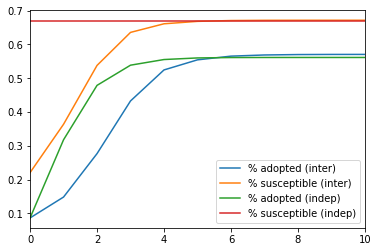

In [26]:
result[['% adopted (inter)', '% susceptible (inter)', '% adopted (indep)', '% susceptible (indep)']].plot();

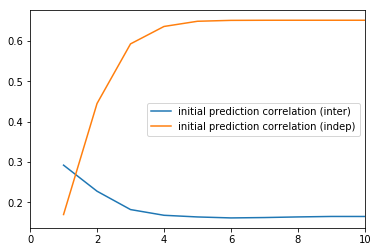

In [27]:
result[['initial prediction correlation (inter)', 'initial prediction correlation (indep)']].plot();

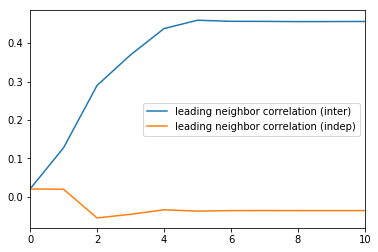

In [28]:
result[['leading neighbor correlation (inter)', 'leading neighbor correlation (indep)']].plot();

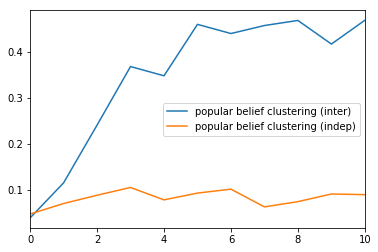

In [29]:
result[['popular belief clustering (inter)', 'popular belief clustering (indep)']].plot();

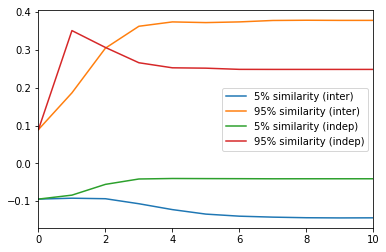

In [30]:
result[['5% similarity (inter)', '95% similarity (inter)', 
        '5% similarity (indep)', '95% similarity (indep)']].plot();

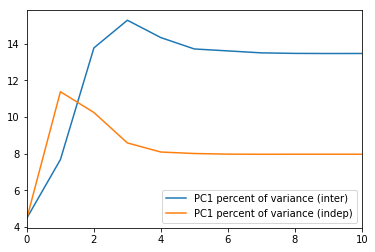

In [31]:
result[['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)']].plot()